# 1- Importing libraries

In [51]:
import pandas # for data analysis
import konlpy # for korean text analysis
import gensim # for word2vec
import tensorflow as tf # for deep learning
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.1.4
0.6.0
4.3.2


# 2- Loading dataset

In [30]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/Users/kenny_jung/aiffel/data/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/Users/kenny_jung/aiffel/data/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [31]:
print(len(train_data), len(test_data))

150000 50000


In [32]:
train_data.sample(5)

,id,document,label
112447,8027075,각박한 세상 속 메마른 정신을 일깨우는 다큐,1
82543,9868651,봤던 안봤던 의리 외치면서 이영화 빠는것까진 봐줄만 하다이거야 그런데 왜 영웅보다 ...,0
83338,6083922,차라리 '이응경의 비디오'에서 몇 커트를 인서트로 사용했더라면 좋았을 것을.,0
94240,5175519,종교/이념이 이토록 중요한 문제인가를 생각해보게 되는 영화. 훌륭함!,1
88029,5902383,너무 많이 알아도 머리가 아픈법.,1


In [33]:
train_data[140000:140010]

,id,document,label
140000,9664848,진짜 꺼이꺼이 울었다 눈물이 계속 나옴,1
140001,916558,차마 눈뜨고 못 보겠다... 졸려서....,0
140002,4629295,잔인해요 마지막에 여자는 살 줄 알았음,0
140003,7474693,비 빠순이들 수고 많다,0
140004,161733,"촬영과 연기, 연출 구성이 엉망이면서 반전에만 목을 맨다",0
140005,8714905,바닐라 스카이가 달콤씁쓸 하다면 이건 말그대로 씁쓸 그 자체인 작품. 바닐라 스카이...,1
140006,6494868,"설마,, 나중에 환경문제. 온난화에 대한 경감심을 심어주기 위해 제작된 영화다 라고...",0
140007,6425220,내 고2 여름방학을 지배한 드라마.. 한번 잡고 보면 끝이 없었지. 빨려들어감,1
140008,2086488,완전변태영화.이해공감 절대불가.여자가 더변태같아.ㅉ다행이다 한국것이 아니라서,0
140009,9806618,뭔가를 알리고 싶어서 일부러 평점 낮췄습니다. 정도전이 나쁜놈이였다고 하시는 분들이...,0


In [34]:
test_data.sample(5)

,id,document,label
8306,8677904,조금도 볼만한 게 없다. 그나마 볼만한 건 성룡의 화이트 패션?,0
6516,7792604,내가본 일본 영화 애니 드라마 중에 최고의 쓰래기 작품,0
37876,1973323,섹스라는 행위를 예술로 승화시켜야 한다는 강박에 빠진 영화..매력없다..,0
2561,2017958,상당히 흥미진진합니다.,1
951,5840369,이거시 박치기다!,1


# 3- Preprocessing

### 3-1 Tokenization, dropping duplicates/na, excluding stopwords

In [35]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab('/opt/homebrew/lib/mecab/dic/mecab-ko-dic')
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', ',', '.', '다', '인', '거', '게']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [36]:

doc_no = 8450
sentence = train_data.iloc[doc_no]['document']
print('Sample sentence in', doc_no, ':', sentence)

sentence_token = tokenizer.morphs(sentence)
print('Tokenized words: ', sentence_token)

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', ',', '.', '다', '인', '거', '게']
sentence_token_wostopwords = [word for word in sentence_token if not word in stopwords]
print('Tokens without stopwords:', sentence_token_wostopwords)

print('Words to index:', X_train[doc_no])
if y_train[doc_no] == 0:
    print('Label:', y_train[doc_no], "Negative review")
else:
    print('Label:', y_train[doc_no], "Positive review")



Sample sentence in 8450 : 좋은 영화. 택시소원도 추천
Tokenized words:  ['좋', '은', '영화', '.', '택시', '소원', '도', '추천']
Tokens without stopwords: ['좋', '영화', '택시', '소원', '추천']
Words to index: [15, 4, 3036, 5855, 277]
Label: 1 Positive review


In [37]:
word_to_index['무섭']

402

In [38]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [39]:
print(index_to_word[500])

뻔한


In [40]:
print("Length of X_train: ", len(X_train))
print("Length of y_train: ", len(y_train))
print("Length of X_test: ", len(X_test))
print("Length of y_test: ", len(y_test))

Length of X_train:  146182
Length of y_train:  146182
Length of X_test:  49157
Length of y_test:  49157


### 3-2 Definition functions

In [41]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3-3 Max len

In [42]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('Average tokens : ', np.mean(num_tokens))
print('Maximum tokens : ', np.max(num_tokens))
print('Token STD : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'{np.sum(num_tokens < max_tokens) / len(num_tokens)}% of all sentence to be included in maxlen token. ')

Average tokens :  14.104935522348327
Maximum tokens :  115
Token STD :  11.523344439813506
pad_sequences maxlen :  37
0.9359830858149166% of all sentence to be included in maxlen token. 


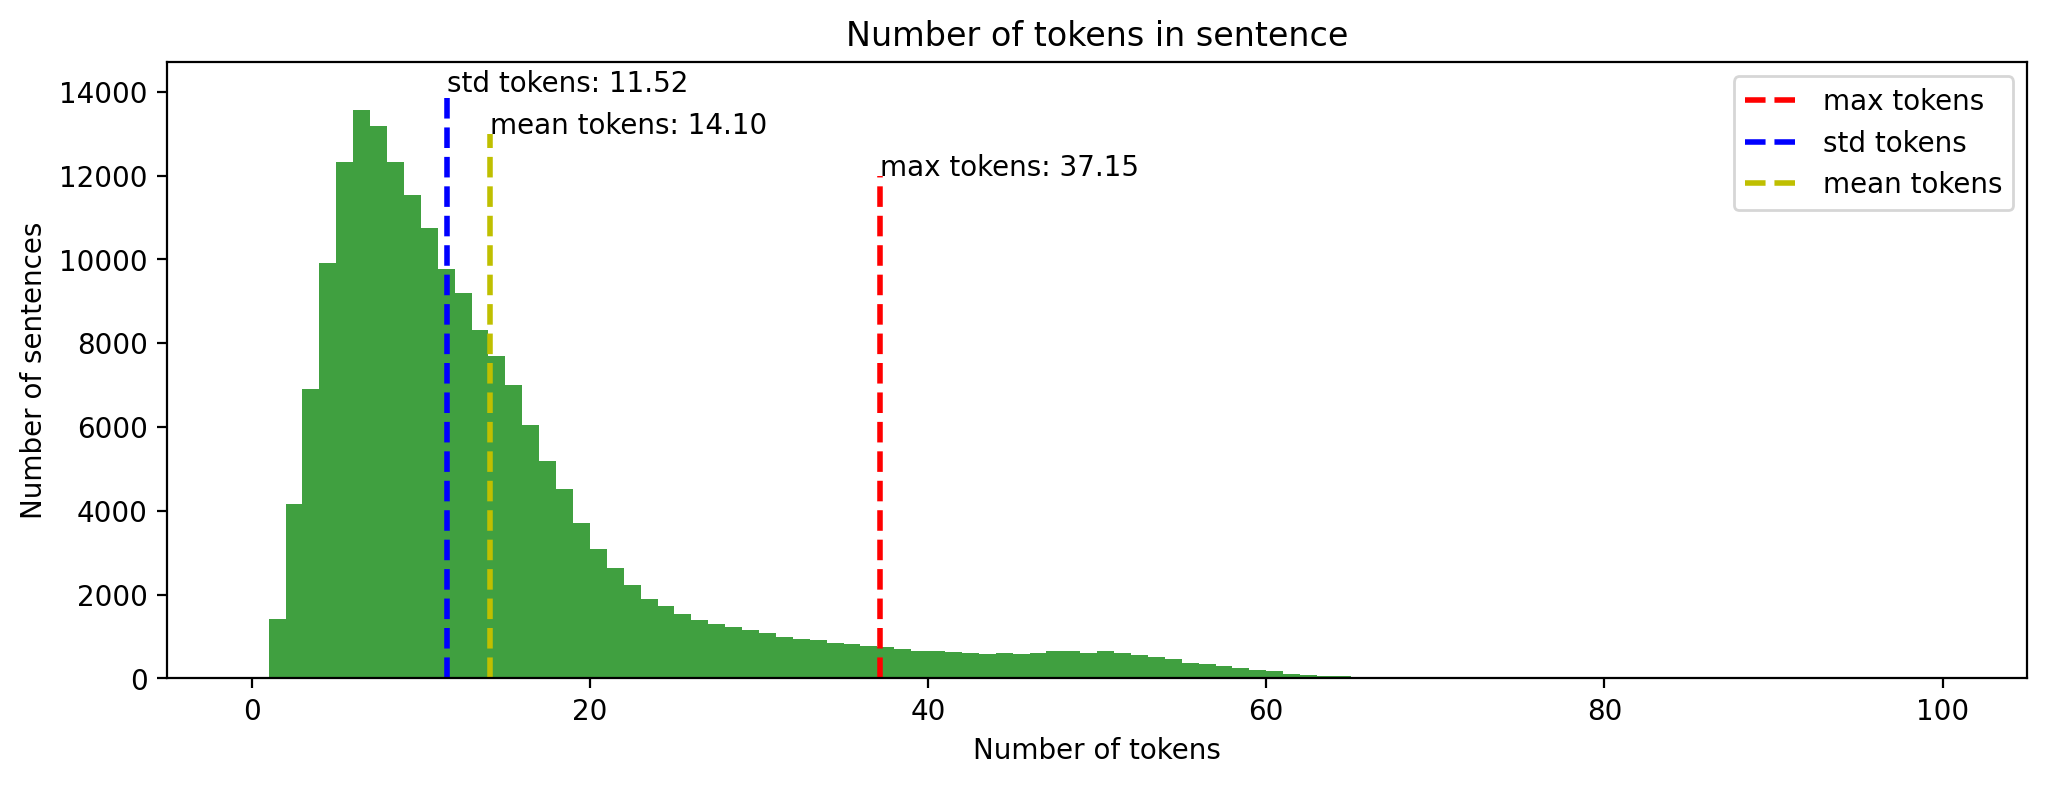

In [43]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 4))
plt.hist(num_tokens, bins=100, range=[0, 100], facecolor='g', alpha=0.75)

plt.vlines([max_tokens], 0, 12000, colors='r',  linestyles='--', linewidth=2, label='max tokens')
plt.vlines([np.std(num_tokens)], 0, 14000, colors='b', linestyles='--', linewidth=2, label='std tokens')
plt.vlines([np.mean(num_tokens)], 0, 13000, colors='y', linestyles='--', linewidth=2, label='mean tokens')

plt.text(max_tokens, 12000, 'max tokens: {:.2f}'.format(max_tokens), ha='left')
plt.text(np.std(num_tokens), 14000, 'std tokens: {:.2f}'.format(np.std(num_tokens)), ha='left')
plt.text(np.mean(num_tokens), 13000, 'mean tokens: {:.2f}'.format(np.mean(num_tokens)), ha='left')

plt.title('Number of tokens in sentence')
plt.xlabel('Number of tokens')
plt.ylabel('Number of sentences')
plt.legend()


### 3-4 Padding

In [44]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)
print(len(X_train))
print(len(X_test))
print(len(X_train)+len(X_test))

(146182, 37)
(49157, 37)
146182
49157
195339


In [45]:
X_train[8450]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   15,
          4, 3036, 5855,  277], dtype=int32)

# 4- Design models

### 4-1 RNN Recurrent Neural Network Model

In [33]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128))   
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # L2 정규화를 적용합니다.
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))  # L2 정규화를 적용합니다.

model.summary()

2024-03-25 10:08:36.213862: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-03-25 10:08:36.213892: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-25 10:08:36.213898: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-25 10:08:36.213934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-25 10:08:36.213951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          200000    
                                                                 
 lstm (LSTM)                 (None, 128)               76288     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 batch_normalization_1 (Bat  (None, 8)                 32        
 chNormalization)                                       

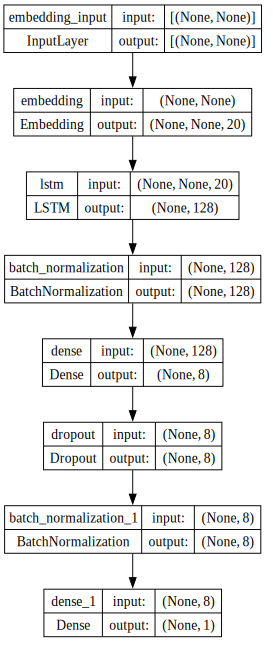

In [34]:
import keras
from IPython.display import SVG
from keras.utils import model_to_dot  
%matplotlib inline
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=70).create(prog='dot', format='svg'))  #dpi를 작게 하면 그래프가 커집니다.

### 4-2 1-D CNN Convolutional Neural Network Model

In [22]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 20   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 20)          200000    
                                                                 
 batch_normalization_4 (Bat  (None, None, 20)          80        
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, None, 16)          1936      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 16)          0         
 g1D)                                                            
                                                                 
 batch_normalization_5 (Bat  (None, None, 16)          64        
 chNormalization)                                                
                                                      

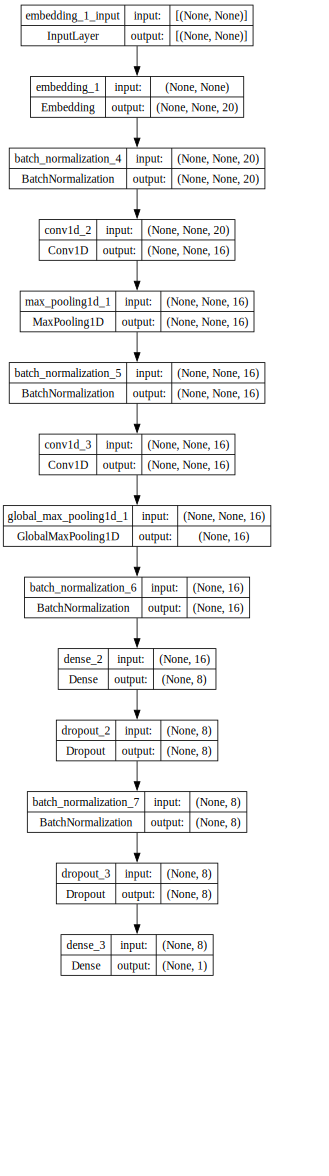

In [23]:
import keras
from IPython.display import SVG
from keras.utils import model_to_dot  
%matplotlib inline
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  #dpi를 작게 하면 그래프가 커집니다.

### 4-3 Simple DNN Model

In [29]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 global_max_pooling1d_2 (Gl  (None, 100)               0         
 obalMaxPooling1D)                                               
                                                                 
 batch_normalization_8 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 808       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 batch_normalization_9 (Bat  (None, 8)                

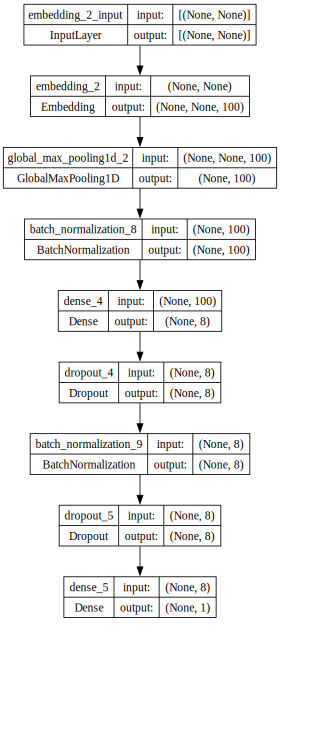

In [30]:
import keras
from IPython.display import SVG
from keras.utils import model_to_dot  
%matplotlib inline
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  #dpi를 작게 하면 그래프가 커집니다.

# 5- Training model

In [35]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((146182, 37), (146182,), (49157, 37), (49157,))

In [36]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(136182, 37)
(136182,)
(10000, 37)
(10000,)


In [37]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.2)

# Create callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3),
    LearningRateScheduler(scheduler)
]

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
epochs=20

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=callbacks) 

Epoch 1/20


2024-03-25 10:08:45.339324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2128/2128 [==============================] - 89s 41ms/step - loss: 0.4592 - accuracy: 0.8078 - val_loss: 0.4298 - val_accuracy: 0.8020 - lr: 0.0010
Epoch 2/20
2128/2128 [==============================] - 85s 40ms/step - loss: 0.3729 - accuracy: 0.8470 - val_loss: 0.3543 - val_accuracy: 0.8451 - lr: 0.0010
Epoch 3/20
2128/2128 [==============================] - 87s 41ms/step - loss: 0.3329 - accuracy: 0.8670 - val_loss: 0.3468 - val_accuracy: 0.8538 - lr: 8.1873e-04
Epoch 4/20
2128/2128 [==============================] - 86s 40ms/step - loss: 0.3062 - accuracy: 0.8783 - val_loss: 0.3367 - val_accuracy: 0.8593 - lr: 6.7032e-04
Epoch 5/20
2128/2128 [==============================] - 85s 40ms/step - loss: 0.2892 - accuracy: 0.8862 - val_loss: 0.3514 - val_accuracy: 0.8550 - lr: 5.4881e-04
Epoch 6/20
2128/2128 [==============================] - 84s 40ms/step - loss: 0.2748 - accuracy: 0.8921 - val_loss: 0.3599 - val_accuracy: 0.8549 - lr: 4.4933e-04
Epoch 7/20
2128/2128 [===================

# 6- Evaluation model

### 6-1 RNN model evaluation

In [38]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 27s - loss: 0.3651 - accuracy: 0.8514 - 27s/epoch - 17ms/step
[0.36505407094955444, 0.8514148592948914]


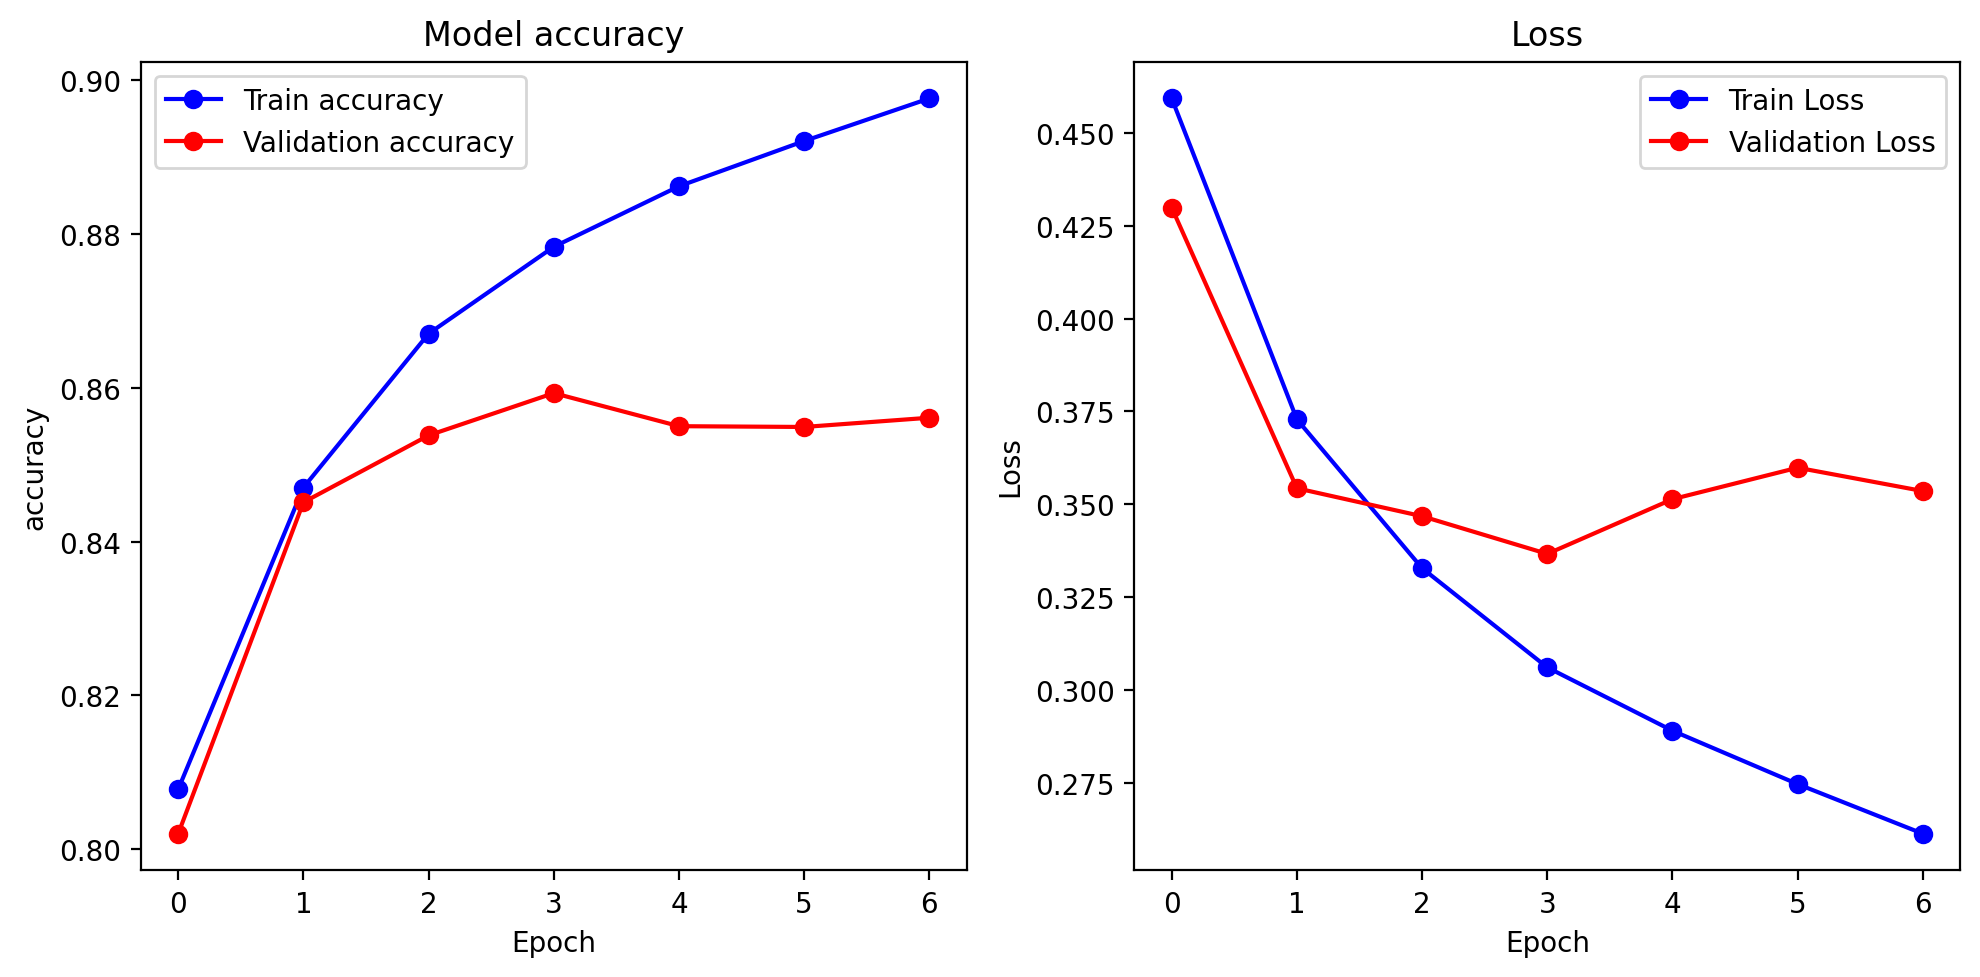

In [39]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 6-2 1-D CNN Model Evaluation

In [27]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 38s - loss: 0.4517 - accuracy: 0.7907 - 38s/epoch - 25ms/step
[0.45173367857933044, 0.7907317280769348]


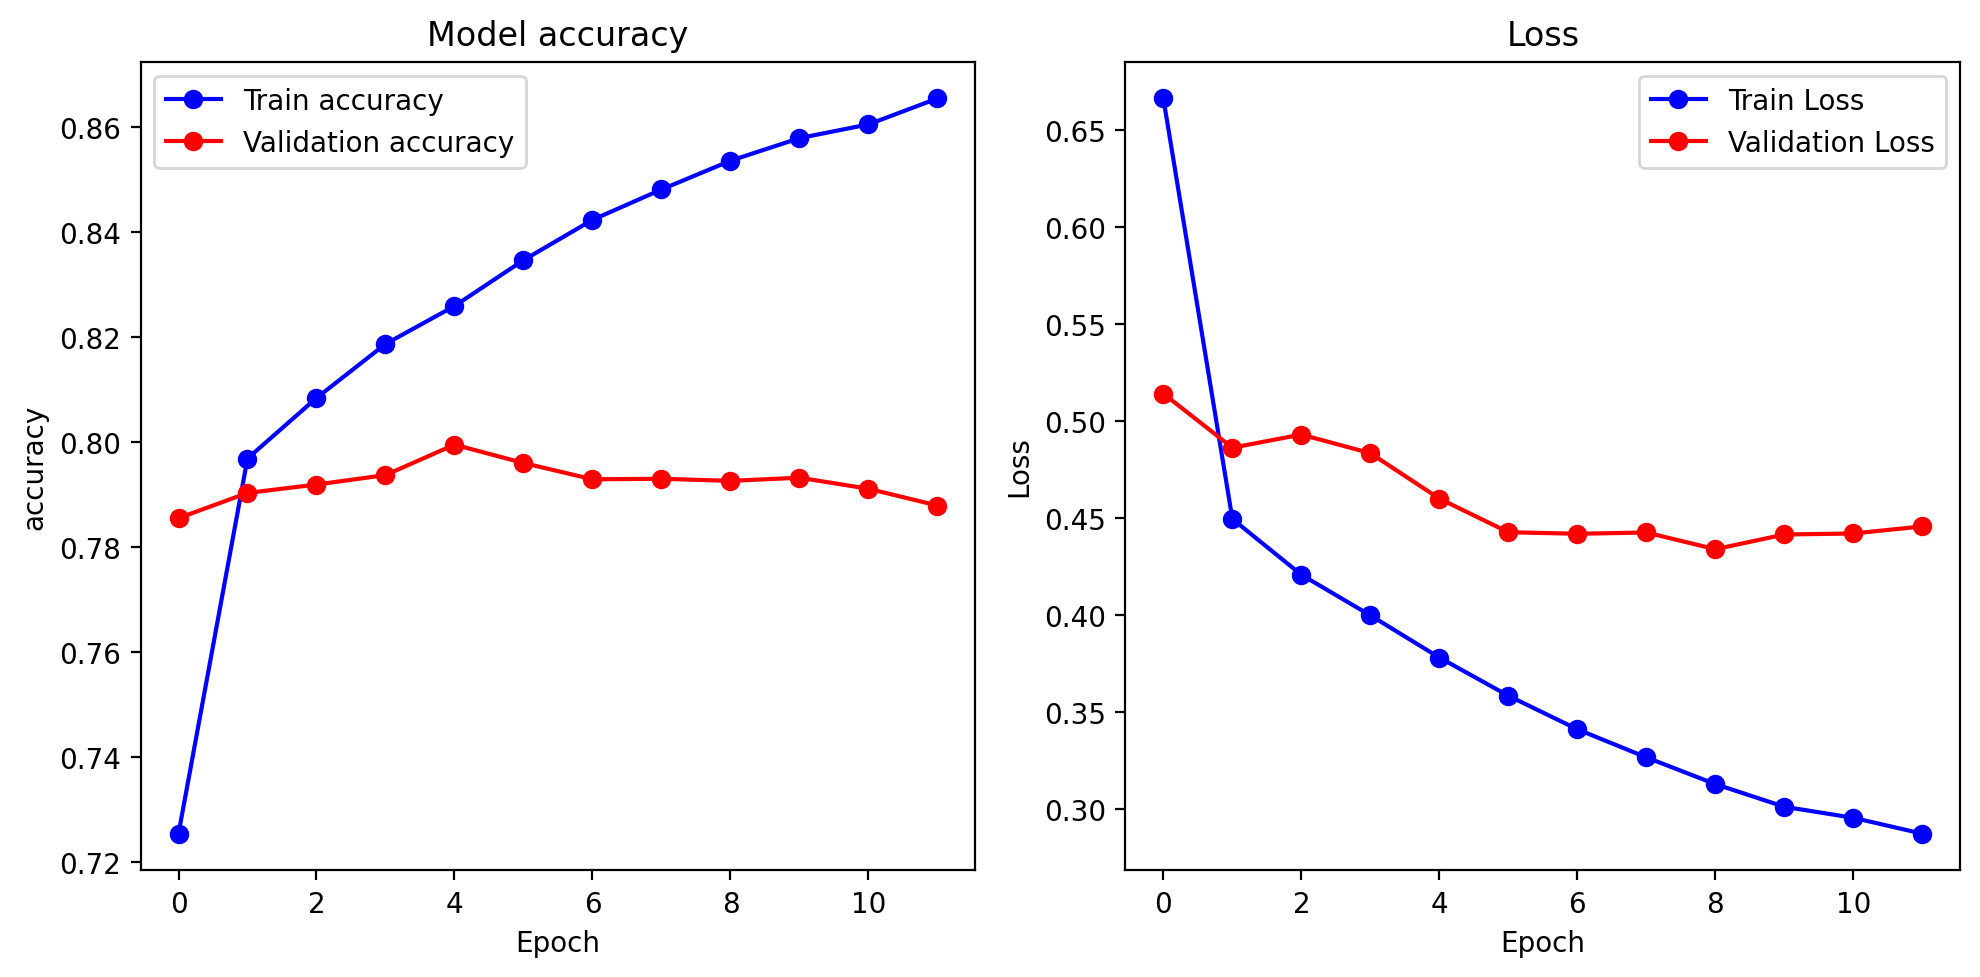

In [28]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 6-3 Basic Evaluation

In [34]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 31s - loss: 0.3892 - accuracy: 0.8468 - 31s/epoch - 20ms/step
[0.3891967535018921, 0.8468173146247864]


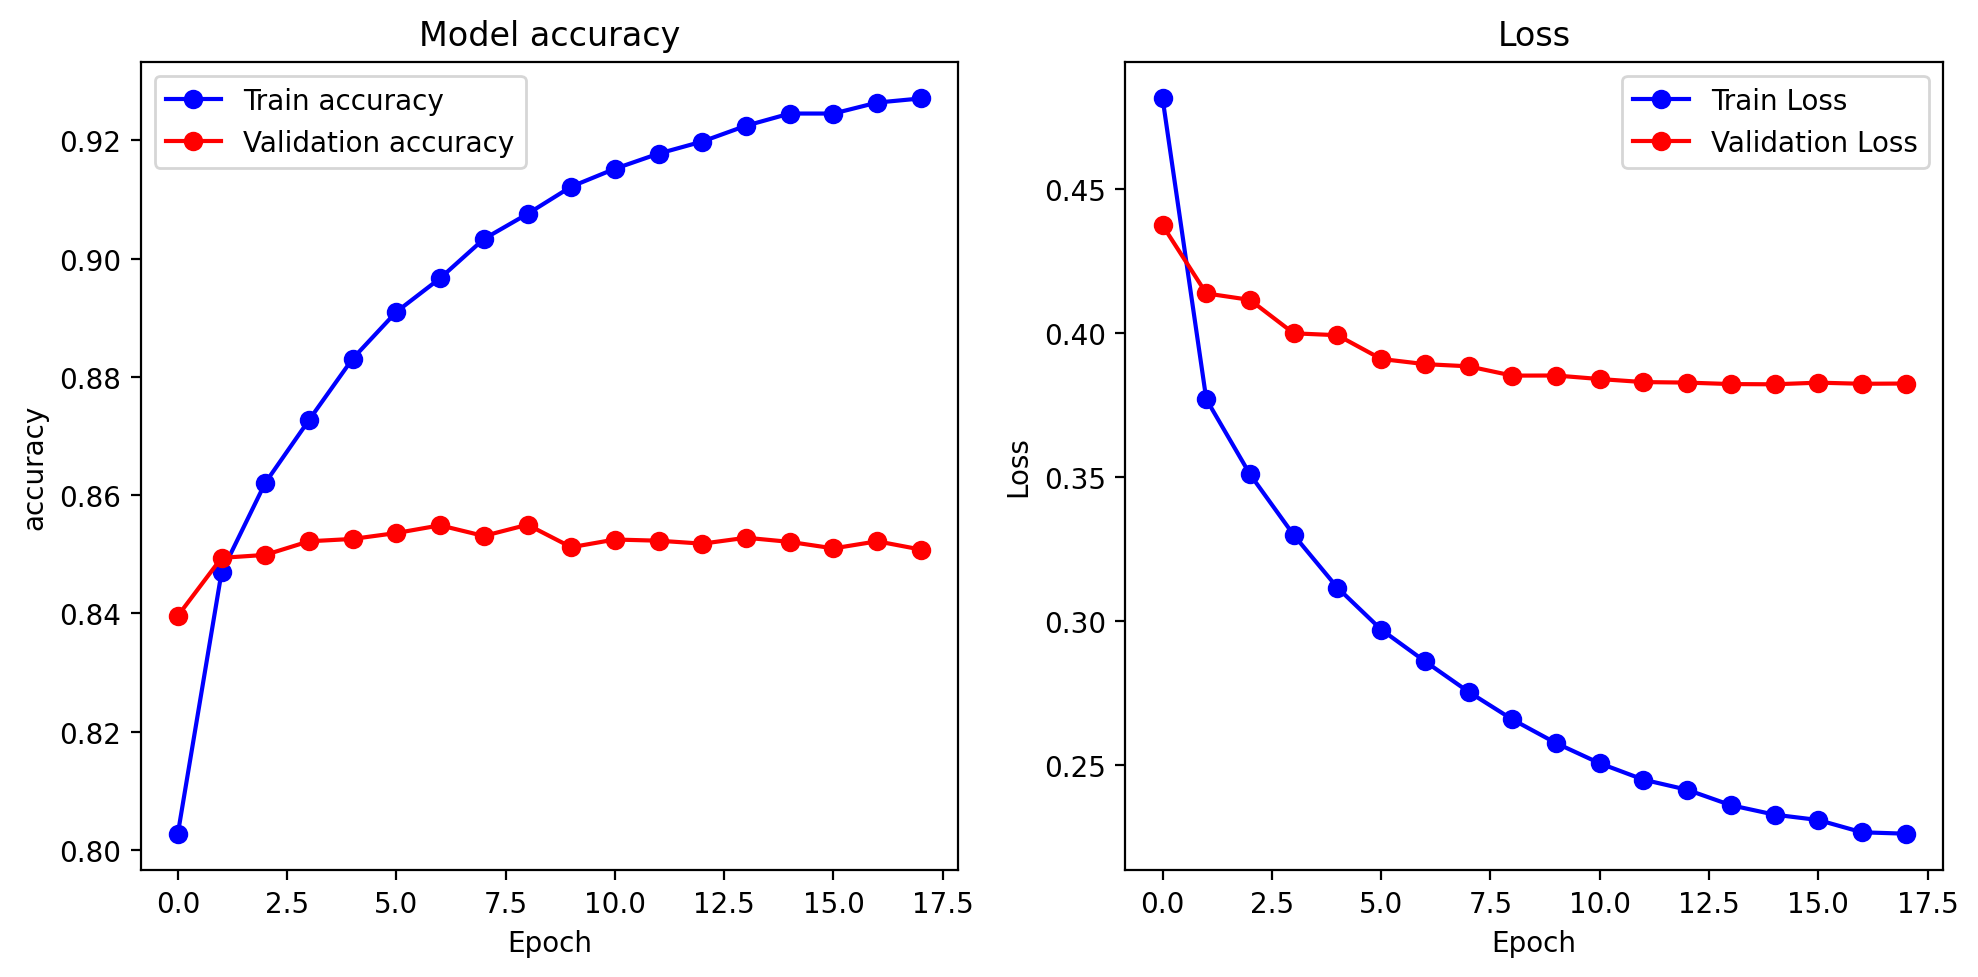

In [35]:
plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 7- word2vec

In [25]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [26]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/Users/kenny_jung/aiffel/data/sentiment_classification/word2vec_naver.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-3.56315635e-02, -5.67974299e-02,  4.15823013e-02,  6.40923902e-02,
       -2.21785661e-02, -3.87879014e-02, -4.87396345e-02, -7.97218308e-02,
        2.24339869e-03, -1.09391391e-01,  1.96169969e-02, -9.21577886e-02,
       -5.59678376e-02,  5.09288907e-02, -2.02046111e-02, -1.52393691e-02,
       -8.34779888e-02,  6.30509481e-02, -4.66468409e-02, -4.67658639e-02,
       -5.65955900e-02, -9.21019837e-02,  8.28204751e-02,  4.53770421e-02,
       -3.27706002e-02, -9.32289585e-02,  3.74036953e-02,  6.68744892e-02,
        3.24201696e-02,  4.01884608e-04, -9.41264350e-03, -6.59795552e-02,
       -3.89203453e-03, -9.37259868e-02, -1.43604083e-02, -1.00044444e-01,
       -1.29255608e-01,  1.93262286e-02, -1.49777532e-02, -4.07648794e-02,
        6.88092858e-02, -8.39564651e-02, -1.18042558e-01, -2.07128767e-02,
       -1.84140839e-02,  1.40544698e-01, -4.47053276e-02,  1.14653870e-01,
        1.14485882e-01,  1.72067620e-02,  7.17111528e-02, -6.39810339e-02,
       -7.88322687e-02,  

# 8- word2vec_ko.model

In [46]:
from gensim.models import KeyedVectors
word2vec_path = '/Users/kenny_jung/aiffel/data/sentiment_classification/word2vec_ko.model'
word_vectors = KeyedVectors.load(word2vec_path)
vector = word_vectors.wv["끝"]
print(vector)

[ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134  -2.6863668   0.7999443
 -0.6957915  -0.5018775   3.5025773   0.21326113 -0.6588098  -1.1900496
  0.61399573  2.1247969   0.1549463   3.0840218   3.1680267  -3.9143991
  3.6073153   0.5315545  -0.3511633  -1.107248    1.7767181  -0.95981866
  2.6072454  -0.00697957 -3.27628     1.558644    0.81922376  1.9231955
  3.7026553  -0.53824735 -0.4920138   2.4657123  -2.620749   -0.08950733
  0.61453176  1.8866426   0.257866   -2.7827141   2.9129577  -0.6313133
  2.0387425  -4.222685   -2.7560544   1.7903243  -1.3080189  -2.5531402
 -0.43849912 -3.1073573  -0.29090825  5.1817617   1.9604833  -5.1421604
 -0.71431434  4.5624633  -0.55525815 -3.3019137   1.6761336  -1.9606539
 -0.2726863   0.2465995   1.2685091   1.6055685   1.8344896   1.2752469
  0.99503314 -2.3348706  -0.9290329  -1.5920266   5.693834    1.1132814
 -0.9603875  -1.970055   -1.0120267  -2.7289615  -2.7759619   

In [72]:
print(vector.shape)
print(len(vector))

(100,)
100


In [75]:
import numpy as np

print("Vector contents: ", vector)

# 벡터 크기 출력
print("Vector size: ", len(vector))  # len() 함수 사용
print("Vector size: ", vector.shape[0])  # shape 속성 사용

Vector contents:  [ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134  -2.6863668   0.7999443
 -0.6957915  -0.5018775   3.5025773   0.21326113 -0.6588098  -1.1900496
  0.61399573  2.1247969   0.1549463   3.0840218   3.1680267  -3.9143991
  3.6073153   0.5315545  -0.3511633  -1.107248    1.7767181  -0.95981866
  2.6072454  -0.00697957 -3.27628     1.558644    0.81922376  1.9231955
  3.7026553  -0.53824735 -0.4920138   2.4657123  -2.620749   -0.08950733
  0.61453176  1.8866426   0.257866   -2.7827141   2.9129577  -0.6313133
  2.0387425  -4.222685   -2.7560544   1.7903243  -1.3080189  -2.5531402
 -0.43849912 -3.1073573  -0.29090825  5.1817617   1.9604833  -5.1421604
 -0.71431434  4.5624633  -0.55525815 -3.3019137   1.6761336  -1.9606539
 -0.2726863   0.2465995   1.2685091   1.6055685   1.8344896   1.2752469
  0.99503314 -2.3348706  -0.9290329  -1.5920266   5.693834    1.1132814
 -0.9603875  -1.970055   -1.0120267  -2.7289

In [88]:
import os

file_path = '/Users/kenny_jung/aiffel/data/sentiment_classification/word2vec_ko.model'  # 파일 경로
file_size = os.path.getsize(file_path)

print(f"The size of word2vec_ko.model is {file_size} bytes")

file_size_in_mb = file_size / (1024 * 1024)
print(f"The size of word2vec_ko.model is {file_size_in_mb} MB")

file_size_in_gb = file_size / (1024 * 1024 * 1024)
print(f"The size of word2vec_ko.model is {file_size_in_gb} GB")

The size of word2vec_ko.model is 19893395 bytes
The size of word2vec_ko.model is 18.97181987762451 MB
The size of word2vec_ko.model is 0.018527167849242687 GB


In [87]:
word_vectors.wv.similar_by_word("행복")

[('사랑', 0.7550067901611328),
 ('소중', 0.7270511388778687),
 ('고독', 0.7223575711250305),
 ('영원', 0.7196939587593079),
 ('친절', 0.7095474600791931),
 ('평온', 0.7088841199874878),
 ('삶', 0.6893890500068665),
 ('안녕', 0.6871559023857117),
 ('애틋', 0.6864286065101624),
 ('꿈', 0.6853601932525635)]

In [48]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [65]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(326, 7, activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(128, 7, activation='relu', padding='same'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))) 

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 37, 100)           1000000   
                                                                 
 conv1d_18 (Conv1D)          (None, 37, 326)           228526    
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 7, 326)            0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 7, 128)            292224    
                                                                 
 global_max_pooling1d_6 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 8)               

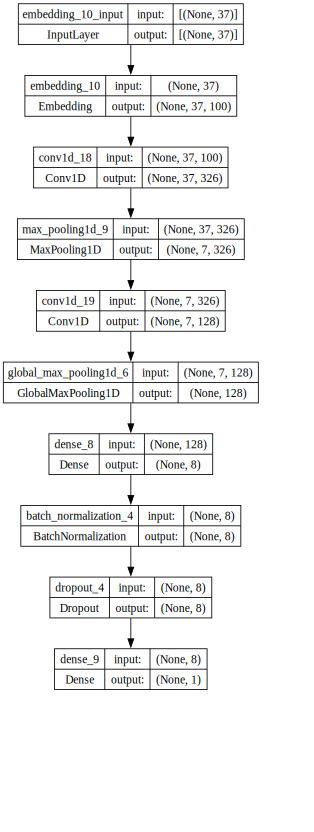

In [66]:
import keras
from IPython.display import SVG
from keras.utils import model_to_dot  
%matplotlib inline
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  #dpi를 작게 하면 그래프가 커집니다.

In [67]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 37)
(136182,)


In [68]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.2)

# Create callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3),
    LearningRateScheduler(scheduler)
]

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
epochs=20

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=callbacks) 

Epoch 1/20


2128/2128 [==============================] - 92s 42ms/step - loss: 0.7351 - accuracy: 0.6738 - val_loss: 0.5523 - val_accuracy: 0.7639 - lr: 1.0000e-04
Epoch 2/20
2128/2128 [==============================] - 90s 42ms/step - loss: 0.5493 - accuracy: 0.7594 - val_loss: 0.4927 - val_accuracy: 0.7899 - lr: 1.0000e-04
Epoch 3/20
2128/2128 [==============================] - 89s 42ms/step - loss: 0.4633 - accuracy: 0.8108 - val_loss: 0.4510 - val_accuracy: 0.8121 - lr: 8.1873e-05
Epoch 4/20
2128/2128 [==============================] - 87s 41ms/step - loss: 0.4000 - accuracy: 0.8452 - val_loss: 0.4362 - val_accuracy: 0.8158 - lr: 6.7032e-05
Epoch 5/20
2128/2128 [==============================] - 88s 41ms/step - loss: 0.3584 - accuracy: 0.8682 - val_loss: 0.4313 - val_accuracy: 0.8230 - lr: 5.4881e-05
Epoch 6/20
2128/2128 [==============================] - 89s 42ms/step - loss: 0.3252 - accuracy: 0.8884 - val_loss: 0.4311 - val_accuracy: 0.8183 - lr: 4.4933e-05
Epoch 7/20
2128/2128 [===========

In [15]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# epochs=20

# model.compile(optimizer=optimizer,
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
              

# history = model.fit(partial_X_train,
#                     partial_y_train,
#                     epochs=epochs,
#                     batch_size=512,
#                     validation_data=(X_val, y_val),
#                     verbose=1)

Epoch 1/20


2024-03-23 09:43:07.563862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-23 09:43:07.611010: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


266/266 [==============================] - 30s 110ms/step - loss: 0.7072 - accuracy: 0.5189 - val_loss: 0.6895 - val_accuracy: 0.5370
Epoch 2/20
266/266 [==============================] - 28s 105ms/step - loss: 0.6542 - accuracy: 0.6099 - val_loss: 0.6209 - val_accuracy: 0.6554
Epoch 3/20
266/266 [==============================] - 28s 105ms/step - loss: 0.5890 - accuracy: 0.6890 - val_loss: 0.5737 - val_accuracy: 0.7067
Epoch 4/20
266/266 [==============================] - 28s 105ms/step - loss: 0.5495 - accuracy: 0.7235 - val_loss: 0.5466 - val_accuracy: 0.7270
Epoch 5/20
266/266 [==============================] - 28s 104ms/step - loss: 0.5255 - accuracy: 0.7421 - val_loss: 0.5272 - val_accuracy: 0.7410
Epoch 6/20
266/266 [==============================] - 28s 104ms/step - loss: 0.5078 - accuracy: 0.7555 - val_loss: 0.5137 - val_accuracy: 0.7508
Epoch 7/20
266/266 [==============================] - 28s 106ms/step - loss: 0.4942 - accuracy: 0.7654 - val_loss: 0.5026 - val_accuracy: 0.7

In [69]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 39s - loss: 0.4767 - accuracy: 0.8102 - 39s/epoch - 25ms/step
[0.47668567299842834, 0.8101796507835388]


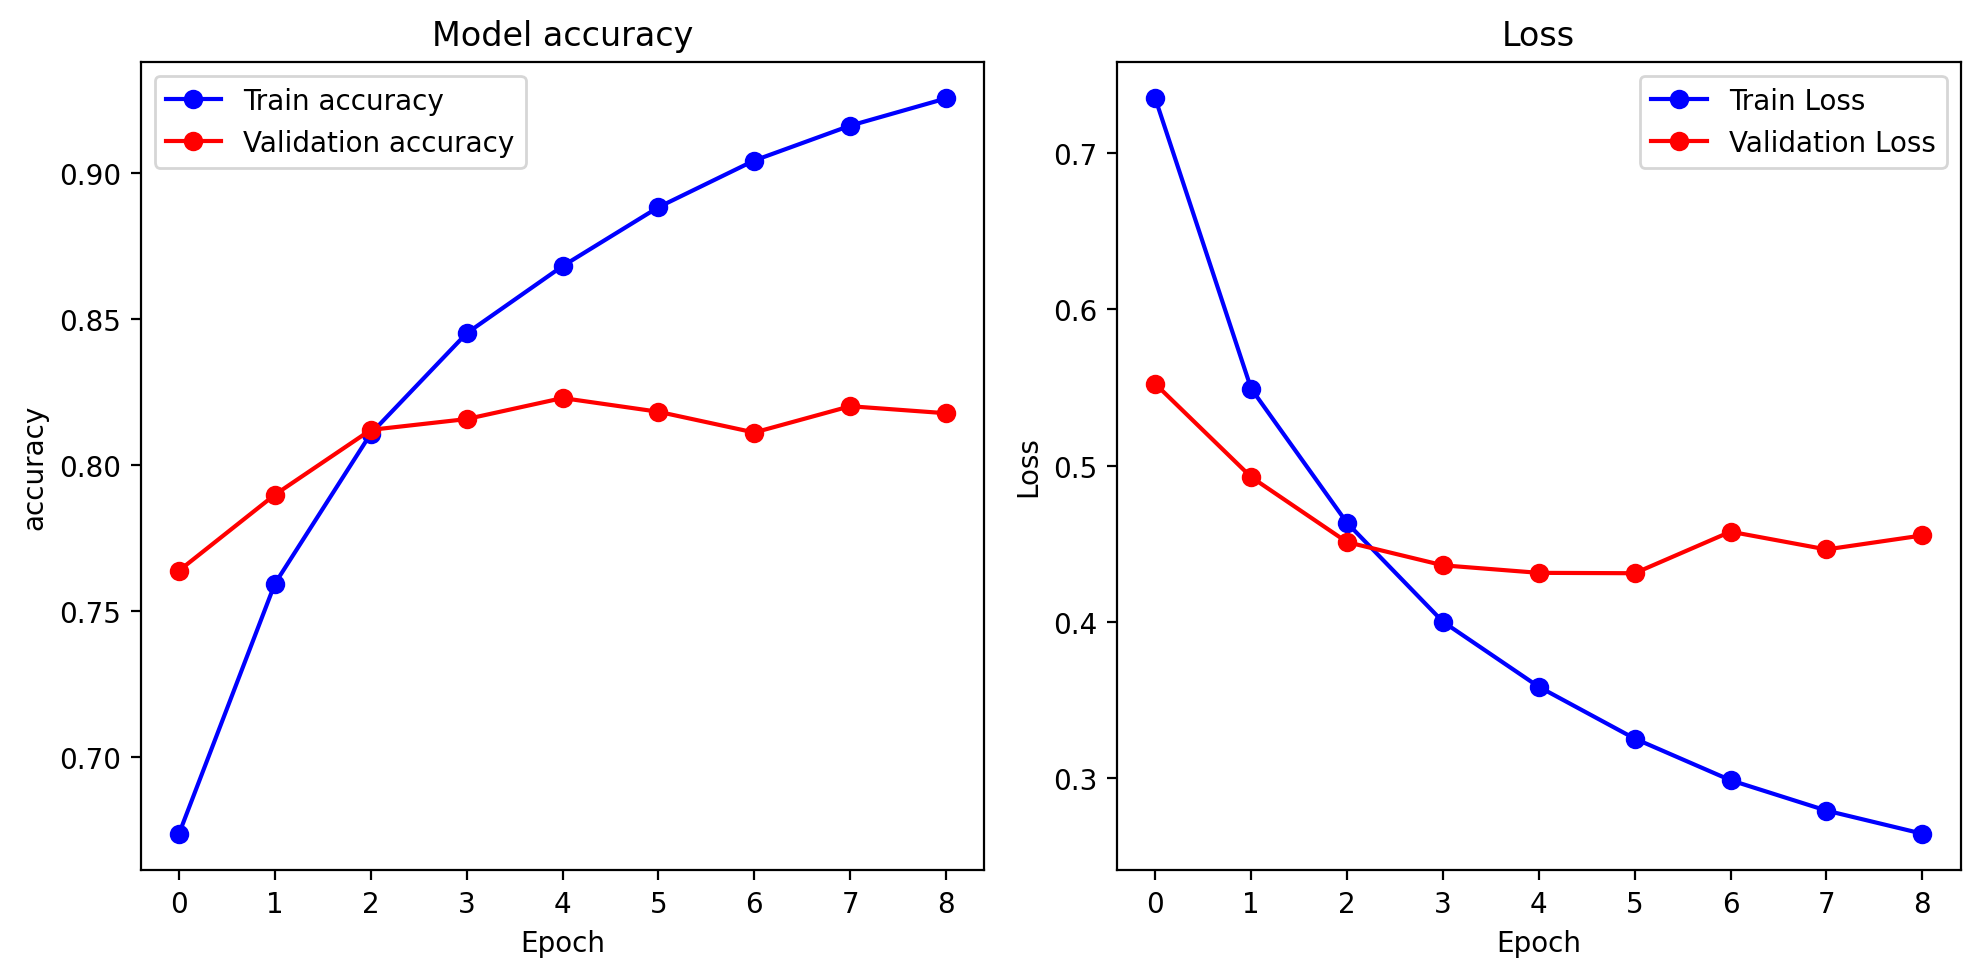

In [70]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#

# 9- Retrospective

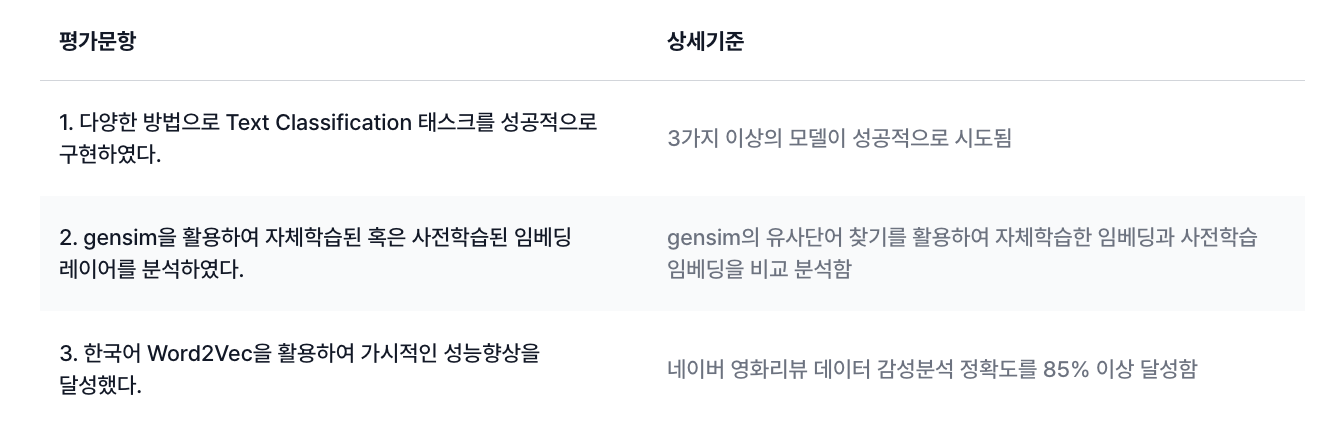

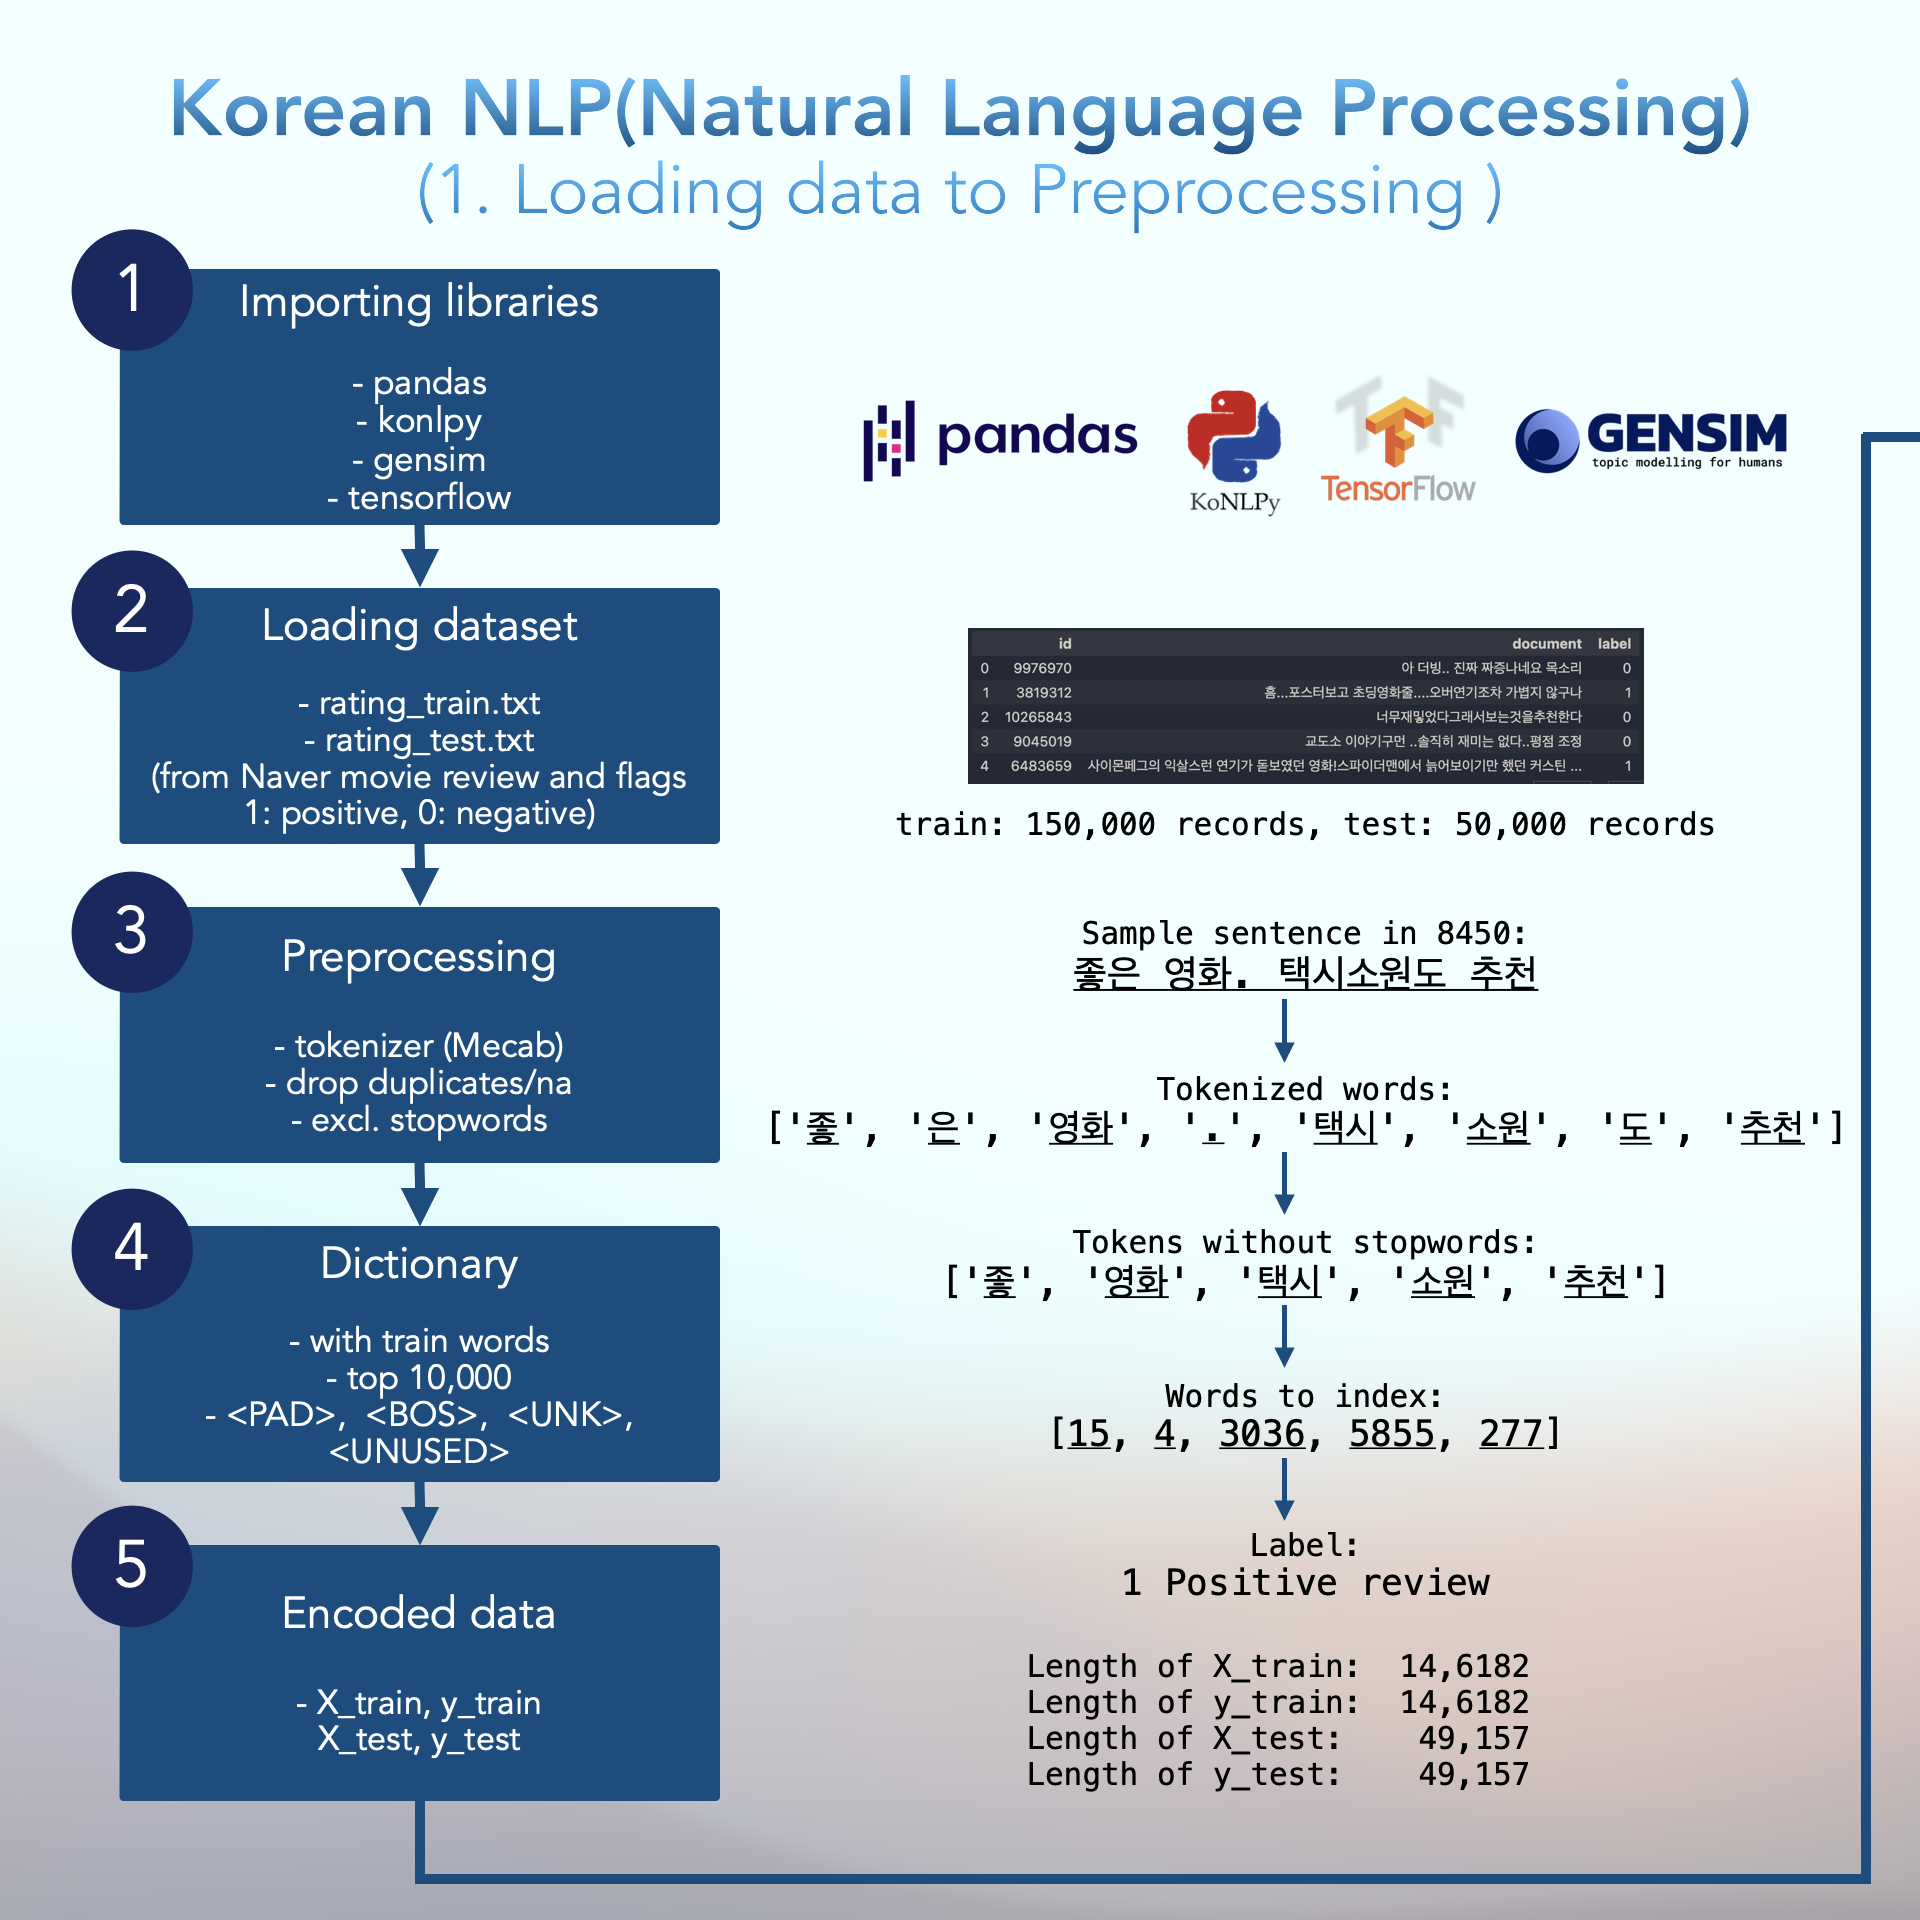

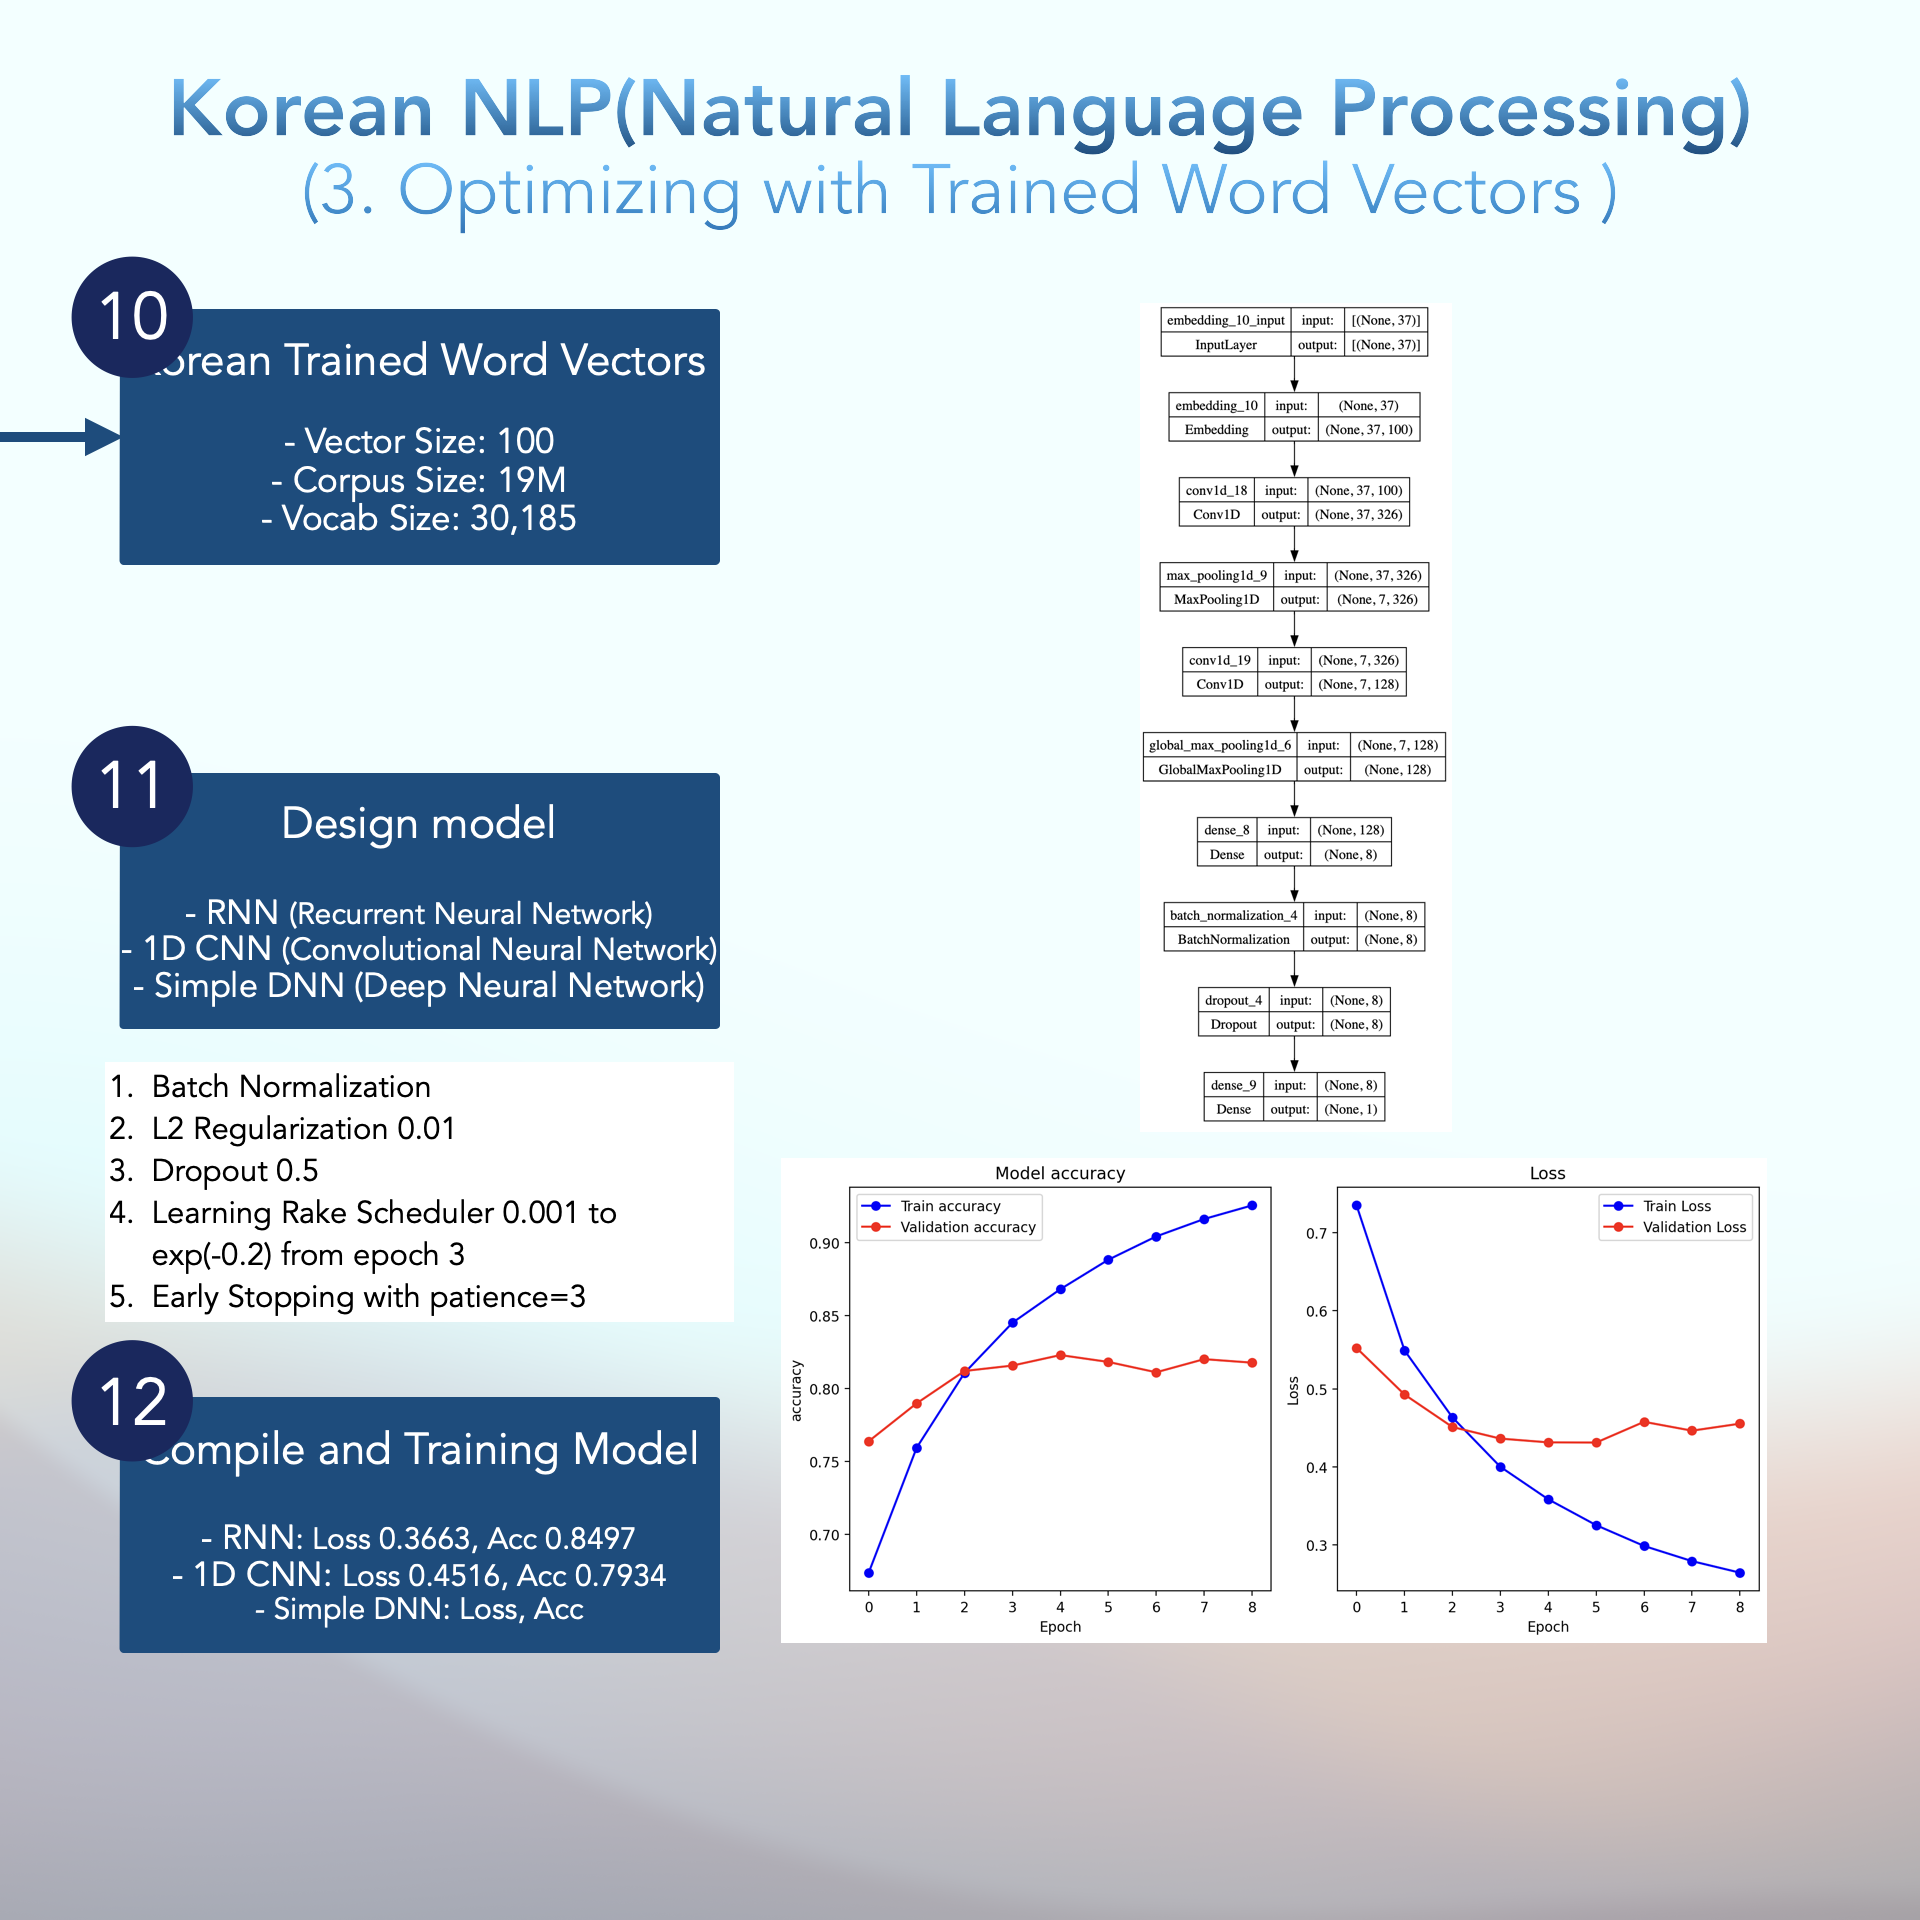